In [5]:
import numpy as np
import numpy.random as rnd
import tensorflow as tf
import gpflow
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter, LinearLocator
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
%matplotlib inline
plt.style.use('ggplot')

In [6]:
def plot_a(x, y, a, title=None):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.gca()
    # surf = ax.plot_surface(x,
    #                       y,
    #                       z,
    #                       cmap=cm.coolwarm,
    #                       linewidth=0,
    #                       antialiased=False)
    surf = ax.contourf(x,
                           y,
                           a,
                           cmap=cm.coolwarm,
                           linewidth=0,
                           antialiased=False)
    # Customize the z axis.
    # ax.set_zlim(-1.01, 1.01)
    # ax.zaxis.set_major_locator(LinearLocator(10))
    # ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.legend(loc='lower right', fontsize=15)
    plt.title(title)
    plt.show()

def gen_data(N=600, num_mixtures=5, low_noise_var=0.005, high_noise_var=0.3, plot_flag=False):
    """
    N - number of training observations
    a - fraction of observations in mode 2 (high noise mode)
    """
    N = N * 1j
    low = -1; high = 1
    x, y = np.mgrid[low:high:N, low:high:N]
    # Need an (N, 2) array of (x, y) pairs.
    xy = np.column_stack([x.flat, y.flat])

    num_mixtures = 5
    means = np.random.rand(num_mixtures, 2) * 2 - 1
    covs = np.random.rand(num_mixtures, 2, 2) * 0.5
    for i in range(num_mixtures):
        covs[i, :, :] = np.diag(np.diag(covs[i, :, :]))

    a = None
    for mean, cov in zip(means, covs):
        if a is None:
            a = multivariate_normal.pdf(xy, mean=mean, cov=cov)
        else:
            a += multivariate_normal.pdf(xy, mean=mean, cov=cov)

    # Reshape back to a (30, 30) grid and rescale to range 0, 1
    a = a.reshape(x.shape)
    a = np.interp(a, (a.min(), a.max()), (0, +1))

    if plot_flag is True:
        plot_a(x, y, a)

    # Generate outputs using alpha
    z = xy.copy()
    a = a.reshape(-1, 1)

    # Add noise where alpha > high_noise_var
    for i in range(z.shape[0]):
        if a[i, 0] > 0.5:
            z[i, :] += high_noise_var * np.random.randn(z[i, :].shape[0])
        else:
            z[i, :] += low_noise_var * np.random.randn(z[i, :].shape[0])

    return xy, a.reshape(-1, 1), z

/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'linewidth'
  from ipykernel import kernelapp as app


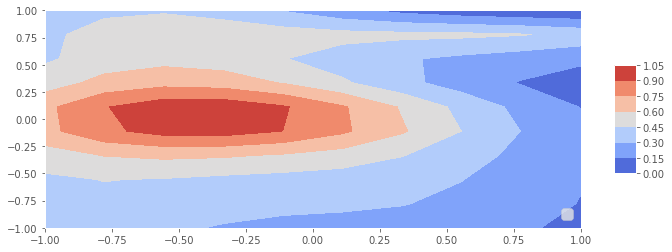

(100, 2)
(100, 2)
(100, 2)


In [12]:
# N = 800 # number of training observations
X, a, Y = gen_data(N=10, num_mixtures=5, plot_flag=True)
print(X.shape)
print(Y.shape)
print(z.shape)

In [13]:
class Logger(gpflow.actions.Action):
    def __init__(self, model):
        self.model = model
        self.logf = []

    def run(self, ctx):
        if (ctx.iteration % 10) == 0:
            # Extract likelihood tensor from Tensorflow session
            likelihood = - ctx.session.run(self.model.likelihood_tensor)
            # Append likelihood value to list
            self.logf.append(likelihood)

In [14]:
from gpflow.training import monitor as mon
def run_adam(model, maxiter=450):
    # Create an Adam Optimiser action
    adam = gpflow.train.AdamOptimizer().make_optimize_action(model)
    # Create a Logger action
    logger = Logger(model)
    actions = [adam, logger]
    # Create optimisation loop that interleaves Adam with Logger
    loop = gpflow.actions.Loop(actions, stop=maxiter)()
    # Bind current TF session to model
    model.anchor(model.enquire_session())
    return logger

def plot_loss(logger):
    plt.plot(-np.array(logger.logf))
    plt.xlabel('iteration (x10)')
    plt.ylabel('ELBO');

In [15]:
def plot_model(m, m1=False, m2=False, a=False, h=False, y=False, save_name=False):
    fig = plt.figure(figsize=(12, 4))
    N = 30j
    low = 0
    high = 5
    x, y = np.mgrid[low:high:N, low:high:N]
    # Need an (N, 2) array of (x, y) pairs.
    xy = np.column_stack([x.flat, y.flat])

    pY_low, pYv_low = m.predict_f(xy)
    pY_low, pYv_low = m.predict_y(xy)
    print(pY_low.shape)
    # plt.fill_between(pX[:, 0], (pY_low-2*pYv_low**0.5)[:, 0], (pY_low+2*pYv_low**0.5)[:, 0], color='m', alpha=0.2, lw=1.5, label='Mode 1 - low noise')

    fig = plt.figure(figsize=(12, 4))
    ax = fig.gca()
    surf = ax.contourf(x,
                           y,
                           pY_low.reshape(x.shape),
                           cmap=cm.coolwarm,
                           linewidth=0,
                           antialiased=False)
    # Customize the z axis.
    # ax.set_zlim(-1.01, 1.01)
    # ax.zaxis.set_major_locator(LinearLocator(10))
    # ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.legend(loc='lower right', fontsize=15)
    plt.show()

#     plt.plot(X, Y, 'x', color='k', label='Observations', alpha=0.2)
#     if m1 or m2 or a or h:
#         plt.plot(m.feature_f_low.Z.value, np.zeros(m.feature_f_low.Z.value.shape), 'k|', mew=2)
#         plt.plot(m.feature_f_high.Z.value, np.zeros(m.feature_f_high.Z.value.shape), 'b|', mew=2)

#     if h is True:
#         a_mu, a_var = m.predict_h(pX) # Predict alpha values at test locations
#         plt.plot(pX, a_mu, color='olive', lw=1.5)
#         plt.fill_between(pX[:, 0], (a_mu-2*a_var**0.5)[:, 0], (a_mu+2*a_var**0.5)[:, 0], color='olive', alpha=0.4, lw=1.5, label='Separation manifold GP')

#     if a is True:
#         a_mu, a_var = m.predict_a(pX) # Predict alpha values at test locations
#         plt.plot(pX, a_mu, color='olive', lw=1.5)
#         plt.fill_between(pX[:, 0], (a_mu-2*a_var**0.5)[:, 0], (a_mu+2*a_var**0.5)[:, 0], color='blue', alpha=0.4, lw=1.5, label='$\\alpha$')

#     if m1 is True:
#         pY_low, pYv_low = m.predict_f_high(pX)
#         line, = plt.plot(pX, pY_low, color='m', alpha=0.6, lw=1.5)
#         plt.fill_between(pX[:, 0], (pY_low-2*pYv_low**0.5)[:, 0], (pY_low+2*pYv_low**0.5)[:, 0], color='m', alpha=0.2, lw=1.5, label='Mode 1 - low noise')

#     if m2 is True:
#         pY_high, pYv_high = m.predict_f_low(pX)
#         line, = plt.plot(pX, pY_high, color='c', alpha=0.6, lw=1.5)
#         plt.fill_between(pX[:, 0], (pY_high-2*pYv_high**0.5)[:, 0], (pY_high+2*pYv_high**0.5)[:, 0], color='c', alpha=0.2, lw=1.5, label='Mode 2 - high noise')

#     if y is True:
#         pY, pYv = m.predict_y(pX)
#         line, = plt.plot(pX, pY, color='royalblue', alpha=0.6, lw=1.5)
#         plt.fill_between(pX[:, 0], (pY-2*pYv**0.5)[:, 0], (pY+2*pYv**0.5)[:, 0], color='royalblue', alpha=0.2, lw=1.5)
# #         plt.fill_between(pX[:, 0], (pY-2*pYv**0.5)[:, 0], (pY+2*pYv**0.5)[:, 0], color='royalblue', alpha=0.2, lw=1.5, label='Combined')

#     fig.legend(loc='lower right', fontsize=15)
#     plt.xlabel('$(\mathbf{s}_{t-1}, \mathbf{a}_{t-1})$', fontsize=30)
#     plt.ylabel('$\mathbf{s}_t$', fontsize=30)
# #     plt.xlim(-1.0, 1.2)
#     plt.tick_params(labelsize=20)
#     if save_name is not False:
#         plt.savefig(save_name, transparent=True, bbox_inches='tight')

In [17]:
import random
M = 50 # number of inducing locations
Z = np.array(random.sample(list(X), M)) # initialisation of inducing input locations (M random points from the training inputs)
k = gpflow.kernels.RBF(input_dim=2)
m_ = gpflow.models.SVGP(X, Y, k, gpflow.likelihoods.Gaussian(), Z, minibatch_size=len(X)) #, minibatch_size=len(Z))
logger = run_adam(m_, gpflow.test_util.notebook_niter(10000))

(900, 2)


ValueError: cannot reshape array of size 1800 into shape (30,30)

<Figure size 864x288 with 0 Axes>

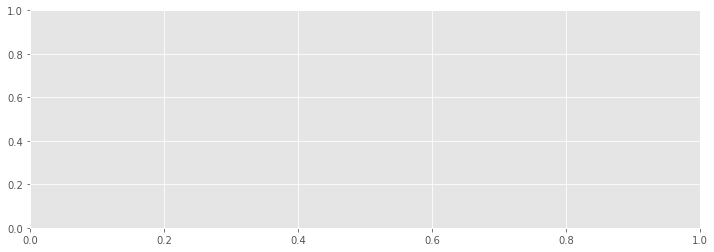

ValueError: cannot reshape array of size 1800 into shape (30,30)

In [18]:
plot_model(m_)

In [19]:
from gpflow import kullback_leiblers, features, settings, transforms
from gpflow.conditionals import conditional, Kuu
from gpflow.decors import params_as_tensors
from gpflow.models.model import GPModel
from gpflow.params import DataHolder, Minibatch, Parameter
from gpflow.mean_functions import Zero
from gpflow.models.model import Model
from gpflow.decors import params_as_tensors, autoflow
from gpflow.quadrature import ndiagquad

float_type = gpflow.settings.float_type

In [20]:
from gpflow.likelihoods import Likelihood, SwitchedLikelihood, Gaussian, Bernoulli

def inv_probit(x):
    jitter = 1e-3  # ensures output is strictly between 0 and 1
    return 0.5 * (1.0 + tf.erf(x / np.sqrt(2.0))) * (1 - 2 * jitter) + jitter


class BernoulliGaussian(Likelihood):
    def __init__(self, variance_low=np.array([0.005, 0.005]), variance_high=np.array([[0.3, 0], [0, 0.3]]), invlink=inv_probit, **kwargs):
        super().__init__(**kwargs)
        self.invlink = invlink
        # self.variance_low = Parameter(
        #     variance_low, transform=transforms.positive, dtype=settings.float_type)
        # self.variance_high = Parameter(
        #     variance_high, transform=transforms.positive, dtype=settings.float_type)
        self.variance_low = Parameter(
            variance_low, transform=transforms.DiagMatrix(2)(transforms.positive), dtype=settings.float_type)
        self.variance_high = Parameter(
            variance_high, transform=transforms.DiagMatrix(2)(transforms.positive), dtype=settings.float_type)
        self.likelihood_bern = Bernoulli()
#         self.variance_low.trainable = False
#         self.variance_high.trainable = False

    @params_as_tensors
    def predict_mean_and_var_f_high(self, Fmu, Fvar):
        return tf.identity(Fmu), Fvar + self.variance_high

    @params_as_tensors
    def predict_mean_and_var_f_low(self, Fmu, Fvar):
        return tf.identity(Fmu), Fvar + self.variance_low

    @params_as_tensors
    def predict_mean_and_var_a(self, Hmu, Hvar):
        return self.likelihood_bern.predict_mean_and_var(Hmu, Hvar)

    @params_as_tensors
    def predict_mean_a(self, H):
        return inv_probit(H)

In [21]:
class BMNSVGP(Model):

    def __init__(self, X, Y, var_low, var_high, minibatch_size=None):
        """
        - X is a data matrix, size N x D
        - Y is a data matrix, size N x P
        """
        Model.__init__(self, name="BMNSVGP")
        if minibatch_size is not None:
            self.X = Minibatch(X, batch_size=minibatch_size, seed=0)
            self.Y = Minibatch(Y, batch_size=minibatch_size, seed=0)
        else:
            self.X = Dataholder(X)
            self.Y = Dataholder(Y)

        self.num_data = X.shape[0]
        self.whiten = True
#         num_inducing = len(self.feature)

        # init separation GP
        self.mean_function_h = Zero(output_dim=1)
        self.kern_h = gpflow.kernels.RBF(input_dim=X.shape[1])
        feat = None
        M = 50
        idx = np.random.choice(range(X.shape[0]), size=M, replace=False)
        Z = X[idx, ...].reshape(-1, 1)
        self.feature_h = features.inducingpoint_wrapper(feat, Z)
        self.feature_h.trainable = False
        # init variational parameters
        # TODO: auto select number of inducing points
        q_mu_h = np.zeros((M, 1)) + rnd.randn(M, 1)
        q_sqrt_h = np.array([10*np.eye(M, dtype=settings.float_type) for _ in range(1)])
        self.q_mu_h, self.q_sqrt_h = self._init_variational_parameters(num_inducing=M, num_latent=1, q_mu=q_mu_h, q_sqrt=q_sqrt_h)
        #         self.q_mu_h, self.q_sqrt_h = self._init_variational_parameters(num_inducing=50, num_latent=1)

        # init 2 dynamics GPs for each output dimension
        kernels = []
        for i in range(2):
            kern_list = [gpflow.kernels.RBF(X.shape[1]) for _ in range(Y.shape[1])] # Create list of kernels for each output
            kernels.append(mk.SeparateIndependentMok(kern_list)) # Create multioutput kernel from kernel list
            Zs = [X[np.random.permutation(len(X))[:M],...].copy() for _ in range(Y.shape[1])] # initialisation of inducing input locations, one set of locations per output
            feature_list = [gpflow.features.InducingPoints(Z) for Z in Zs] # initialise as list inducing features
            feature = mf.SeparateIndependentMof(feature_list) # create multioutput features from feature_list

        # init 2 dynamics GPs for each output dimension
        self.mean_function_f_low = []
        self.mean_function_f_high = []
        # for i in range(Y.shape[1]):
        #     # init mean functions
        #     self.mean_function_f_low[i] = Zero(output_dim=1)
        #     self.mean_function_f_high[i] = Zero(output_dim=1)

        #     # init kernels
        #     kern_list = [gpflow.kernels.RBF(input_dim=X.shape[1]) for _ in range(Y.shape[1])]

        #     # init sparse features
        #     self.feature_f_low[i] = features.inducingpoint_wrapper(feat, Z)
        #     self.feature_f_low[i].trainable = False
        #     self.feature_f_high[i] = features.inducingpoint_wrapper(feat, Z)
        #     self.feature_f_high[i].trainable = False

        #     # init variational inducing points
        #     self.q_mu_f_low[i], self.q_sqrt_f_low[i] = self._init_variational_parameters(num_inducing=M, num_latent=1)
        #     self.q_mu_f_high[i], self.q_sqrt_f_high[i] = self._init_variational_parameters(num_inducing=M, num_latent=1)

        # init likelihood
        self.likelihood = BernoulliGaussian(variance_low=var_low, variance_high=var_high)


    def _init_variational_parameters(self, num_inducing, num_latent, q_mu=None, q_sqrt=None, q_diag=None):
        q_mu = np.zeros((num_inducing, num_latent)) if q_mu is None else q_mu
        q_mu = Parameter(q_mu, dtype=settings.float_type)  # M x P

        if q_sqrt is None:
            if q_diag:
                q_sqrt = Parameter(np.ones((num_inducing, num_latent), dtype=settings.float_type),
                                        transform=transforms.positive)  # M x P
            else:
                q_sqrt = np.array([np.eye(num_inducing, dtype=settings.float_type) for _ in range(num_latent)])
                q_sqrt = Parameter(q_sqrt, transform=transforms.LowerTriangular(num_inducing, num_latent))  # P x M x M
        else:
            if q_diag:
                assert q_sqrt.ndim == 2
                num_latent = q_sqrt.shape[1]
                q_sqrt = Parameter(q_sqrt, transform=transforms.positive)  # M x L/P
            else:
                assert q_sqrt.ndim == 3
                num_latent = q_sqrt.shape[0]
                num_inducing = q_sqrt.shape[1]
                q_sqrt = Parameter(q_sqrt, transform=transforms.LowerTriangular(num_inducing, num_latent))  # L/P x M x M
        return q_mu, q_sqrt

    @params_as_tensors
    def build_prior_KL(self, feature, kern, q_mu, q_sqrt):
        if self.whiten:
            K = None
        else:
            K = Kuu(feature, kern, jitter=settings.numerics.jitter_level)  # (P x) x M x M

        return kullback_leiblers.gauss_kl(q_mu, q_sqrt, K)

    def _sample_e_h(self, dist_h, f_low, f_high, num_samples=1000):
        h = tf.reshape(dist_h.sample(num_samples), [-1, num_samples])
        p_a_0 = 1 - inv_probit(h)

        dist_y_low = tf.distributions.Normal(loc=f_low, scale=self.likelihood.variance_low)
        dist_y_high = tf.distributions.Normal(loc=f_high, scale=self.likelihood.variance_high)
        p_y_low = dist_y_low.prob(self.Y)
        p_y_high = dist_y_high.prob(self.Y)
        return 1./(num_samples**2) * tf.reduce_sum(tf.log(p_y_low * p_a_0 + p_y_high * (1 - p_a_0)), axis=1)

    def _sample_e_f(self, dist_f_low, dist_f_high, h, num_samples=1000):
        p_a_0 = 1 - inv_probit(h)

        f_low = tf.reshape(dist_f_low.sample(num_samples), [-1, num_samples])
        f_high = tf.reshape(dist_f_high.sample(num_samples), [-1, num_samples])

        dist_y_low = tf.distributions.Normal(loc=f_low, scale=self.likelihood.variance_low)
        dist_y_high = tf.distributions.Normal(loc=f_high, scale=self.likelihood.variance_high)
        p_y_low = dist_y_low.prob(self.Y)
        p_y_high = dist_y_high.prob(self.Y)
        return 1./(num_samples**2) * tf.reduce_sum(tf.log(p_y_low * p_a_0 + p_y_high * (1 - p_a_0)), axis=1)

    @params_as_tensors
    def _build_likelihood(self):
        """
        This gives a variational bound on the model likelihood.
        """
        # Get prior KL.
        KL_h = self.build_prior_KL(self.feature_h, self.kern_h, self.q_mu_h, self.q_sqrt_h)

        # Lets get conditional p(h_n | U_h, x_n) for all N
        h_mean, h_var = self._build_predict_h(self.X, full_cov=False, full_output_cov=False)

        KL_f_low = 0; KL_f_high = 0
        for i in range(self.Y.shape[1]):
            # Get prior KL.
            KL_f_low += self.build_prior_KL(self.feature_f_low[i], self.kern_f_low[i], self.q_mu_f_low[i], self.q_sqrt_f_low[i])
            KL_f_high += self.build_prior_KL(self.feature_f_high[i], self.kern_f_high[i], self.q_mu_f_high[i], self.q_sqrt_f_high[i])

            # Lets get conditionals p(f_n_1 | U_f_1, x_n) and p(f_n_2 | U_f_2, x_n) for all N
            f_mean_low, f_var_low = self._build_predict_f_low(self.X, full_cov=False, full_output_cov=False)
            f_mean_high, f_var_high = self._build_predict_f_high(self.X, full_cov=False, full_output_cov=False)

        dist_f_low = tf.distributions.Normal(loc=f_mean_low, scale=f_var_low)
        dist_f_high = tf.distributions.Normal(loc=f_mean_high, scale=f_var_high)
        dist_h = tf.distributions.Normal(loc=h_mean, scale=h_var)

        f_high = f_mean_high
        f_low = f_mean_low
        var_exp_h = self._sample_e_h(dist_h, f_low, f_high, num_samples=1)
        var_exp_f = self._sample_e_f(dist_f_low, dist_f_high, h_mean, num_samples=1)
        var_exp = var_exp_f + var_exp_h

        # re-scale for minibatch size
        scale = tf.cast(self.num_data, settings.float_type) / tf.cast(tf.shape(self.X)[0], settings.float_type)
        return tf.reduce_sum(var_exp) * scale - KL_f_low - KL_f_high - KL_h

    @params_as_tensors
    def _build_predict_h(self, Xnew, full_cov=False, full_output_cov=False):
        mu, var = conditional(Xnew, self.feature_h, self.kern_h, self.q_mu_h, q_sqrt=self.q_sqrt_h, full_cov=full_cov,
                              white=self.whiten, full_output_cov=full_output_cov)
        return mu + self.mean_function_h(Xnew), var

    @params_as_tensors
    def _build_predict_f_low(self, Xnew, full_cov=False, full_output_cov=False):
        mu = tf.empty(Xnew.shape[0], self.Y.shape[1])
        var = tf.empty(Xnew.shape[0], self.Y.shape[1], self.Y.shape[1])
        for i in range(self.Y.shape[1]):
            mu[:, i], var[:, i] = conditional(Xnew, self.feature_f_low[i], self.kern_f_low[i], self.q_mu_f_low[i], q_sqrt=self.q_sqrt_f_low[i], full_cov=full_cov,
                                  white=self.whiten, full_output_cov=full_output_cov)
            mu[:, i] += self.mean_function_f_low[i](Xnew)
        return mu, var

    @params_as_tensors
    def _build_predict_f_high(self, Xnew, full_cov=False, full_output_cov=False):
        mu, var = conditional(Xnew, self.feature_f_high, self.kern_f_high, self.q_mu_f_high, q_sqrt=self.q_sqrt_f_high, full_cov=full_cov,
                              white=self.whiten, full_output_cov=full_output_cov)
        return mu + self.mean_function_f_high(Xnew), var

    @autoflow((settings.float_type, [None, None]))
    def predict_a(self, Xnew):
        h_mean, h_var = self._build_predict_h(Xnew)
        return self.likelihood.predict_mean_and_var_a(h_mean, h_var)

    @autoflow((settings.float_type, [None, None]))
    def predict_h(self, Xnew):
        return self._build_predict_h(Xnew)

    @autoflow((settings.float_type, [None, None]))
    def predict_f_low(self, Xnew):
        pred_f_mean, pred_f_var = self._build_predict_f_low(Xnew)
        return self.likelihood.predict_mean_and_var_f_low(pred_f_mean, pred_f_var)

    @autoflow((settings.float_type, [None, None]))
    def predict_f_high(self, Xnew):
        pred_f_mean, pred_f_var = self._build_predict_f_high(Xnew)
        return self.likelihood.predict_mean_and_var_f_high(pred_f_mean, pred_f_var)

#     @autoflow((settings.float_type, [None, None]))
    def predict_y(self, Xnew):
        # TODO: how to incorporate unc in assignment???
        pred_f_mean_low, pred_f_var_low = self.predict_f_low(Xnew)
        pred_f_mean_high, pred_f_var_high = self.predict_f_high(Xnew)
        pred_a_mean, pred_a_var = self.predict_a(Xnew)
        f_mean = pred_f_mean_low * (1-pred_a_mean) + pred_f_mean_high * pred_a_mean
        f_var = pred_f_var_low * (1-pred_a_mean) + pred_f_var_high * pred_a_mean
        return f_mean, f_var

In [22]:
gpflow.reset_default_graph_and_session()
print(X.shape)
print(Y.shape)
var_low = np.array([[0.005, 0.], [0., 0.005]])
var_high = np.array([[0.3, 0.], [0., 0.3]])
with gpflow.defer_build():
    m = BMNSVGP(X, Y, var_low=var_low, var_high=var_high, minibatch_size=100)
#     m = BMNSVGP(X, Y, var_low=0.001, var_high=0.7, minibatch_size=100)
m.compile()

(100, 2)
(100, 2)


NameError: name 'gpf' is not defined

In [167]:
logger = run_adam(m, maxiter=gpflow.test_util.notebook_niter(15000))

InvalidArgumentError: In[0] mismatch In[1] shape: 100 vs. 50: [100,100] [50,1] 1 0
	 [[node BMNSVGP/conditional/base_conditional/MatMul (defined at /Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/gpflow/conditionals.py:235) ]]

Errors may have originated from an input operation.
Input Source operations connected to node BMNSVGP/conditional/base_conditional/MatMul:
 BMNSVGP/conditional/base_conditional/BroadcastTo_2 (defined at /Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/gpflow/conditionals.py:234)	
 BMNSVGP/conditional/base_conditional/MatrixTriangularSolve (defined at /Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/gpflow/conditionals.py:217)

Original stack trace for 'BMNSVGP/conditional/base_conditional/MatMul':
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-166-ef7908007a57>", line 9, in <module>
    m.compile()
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/gpflow/core/node.py", line 58, in compile
    self.build()
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/gpflow/core/node.py", line 156, in build
    self._build()
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/gpflow/models/model.py", line 80, in _build
    likelihood = self._build_likelihood()
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/gpflow/decors.py", line 67, in tensor_mode_wrapper
    result = method(obj, *args, **kwargs)
  File "<ipython-input-165-9c60d4d9fed7>", line 127, in _build_likelihood
    h_mean, h_var = self._build_predict_h(self.X, full_cov=False, full_output_cov=False)
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/gpflow/decors.py", line 67, in tensor_mode_wrapper
    result = method(obj, *args, **kwargs)
  File "<ipython-input-165-9c60d4d9fed7>", line 150, in _build_predict_h
    white=self.whiten, full_output_cov=full_output_cov)
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/multipledispatch/dispatcher.py", line 278, in __call__
    return func(*args, **kwargs)
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/gpflow/decors.py", line 49, in name_scope_wrapper
    return method(*args, **kwargs)
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/gpflow/conditionals.py", line 74, in _conditional
    q_sqrt=q_sqrt, white=white)  # N x R,  R x N x N or N x R
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/gpflow/decors.py", line 49, in name_scope_wrapper
    return method(*args, **kwargs)
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/gpflow/conditionals.py", line 235, in base_conditional
    fmean = tf.matmul(A, f, transpose_a=True)  # [...,N,R]
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py", line 2609, in matmul
    return batch_mat_mul_fn(a, b, adj_x=adjoint_a, adj_y=adjoint_b, name=name)
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1677, in batch_mat_mul_v2
    "BatchMatMulV2", x=x, y=y, adj_x=adj_x, adj_y=adj_y, name=name)
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/Users/aidanscannell/.virtualenvs/gp-env/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


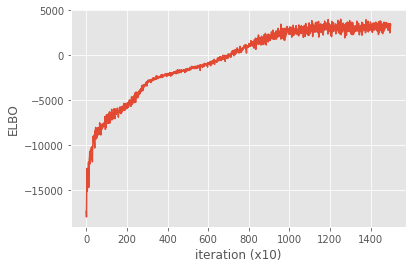

In [47]:
plot_loss(logger)

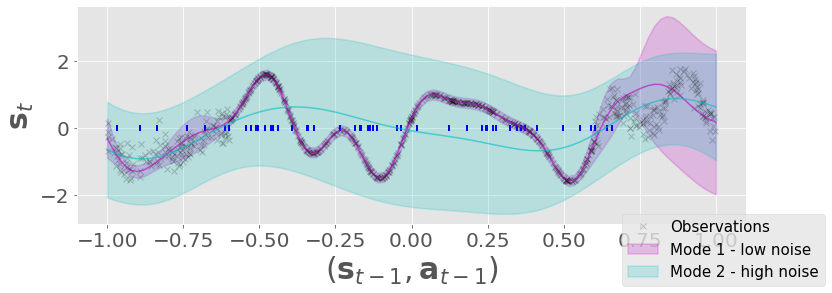

In [55]:
# plot_model(m, m1=True, m2=True, h=True, a=False)
plot_model(m, m1=True, m2=True, a=False, save_name='img/joint_sep.pdf')

In [56]:
def plot_a(m, a, save_name=False):
    fig = plt.figure(figsize=(12, 4))
    pX = np.linspace(-1, 1, 100)[:, None] # Test locations

    plt.plot(XX, a, '-', color='k', label='True $\\alpha$', alpha=0.9)
    plt.plot(m.feature_f_low.Z.value, np.zeros(m.feature_f_low.Z.value.shape), 'k|', mew=2)
    plt.plot(m.feature_f_high.Z.value, np.zeros(m.feature_f_high.Z.value.shape), 'b|', mew=2)
    a_mu, a_var = m.predict_a(pX) # Predict alpha values at test locations
#     plt.plot(pX, a_mu, color='olive', lw=1.5)
#     plt.fill_between(pX[:, 0], (a_mu-2*a_var**0.5)[:, 0], (a_mu+2*a_var**0.5)[:, 0], color='blue', alpha=0.4, lw=1.5, label='$\\alpha$')
    plt.plot(pX, -a_mu+1., color='olive', lw=1.5)
    plt.fill_between(pX[:, 0], -(a_mu-2*a_var**0.5)[:, 0]+1., -(a_mu+2*a_var**0.5)[:, 0]+1., color='blue', alpha=0.4, lw=1.5, label='Learnt $\\alpha$')
    fig.legend(loc='lower right', fontsize=15)
    plt.xlabel('$(\mathbf{s}_{t-1}, \mathbf{a}_{t-1})$', fontsize=30)
    plt.ylabel('$\\alpha$', fontsize=30)
#     plt.xlim(-1.0, 1.2)
    plt.tick_params(labelsize=20)
    if save_name is not False:
        plt.savefig(save_name, transparent=True, bbox_inches='tight')

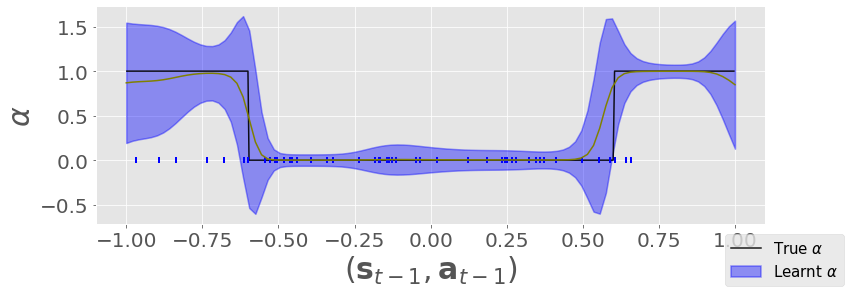

In [57]:
# plot_model(m, a=True)
XX = np.sort(X, axis=0)
a = np.zeros([N, 1])
a[XX<-0.6] = 1
a[XX>0.6] = 1
# plot_a(m, a, save_name='img/learnt_alpha.pdf')
plot_a(m, a)
# plt.savefig("img/joint_all.pdf", transparent=True, bbox_inches='tight')

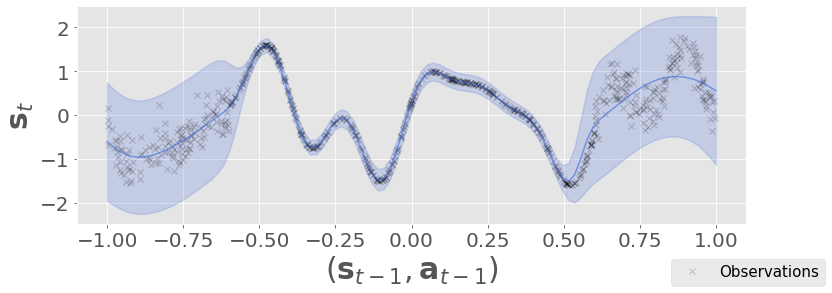

In [58]:
plot_model(m, y=True)
# plt.savefig("img/joint_combined.pdf", transparent=True, bbox_inches='tight')

In [52]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
BMNSVGP/feature_f_high/Z,Parameter,None,(none),False,"(50, 1)",True,"[[0.24945542172719937], [-0.967927461509521], ..."
BMNSVGP/feature_f_low/Z,Parameter,None,(none),False,"(50, 1)",True,"[[0.24945542172719937], [-0.967927461509521], ..."
BMNSVGP/feature_h/Z,Parameter,None,(none),False,"(50, 1)",True,"[[0.24945542172719937], [-0.967927461509521], ..."
BMNSVGP/kern_f_high/lengthscales,Parameter,None,+ve,True,(),True,0.11078321707218727
BMNSVGP/kern_f_high/variance,Parameter,None,+ve,True,(),True,1.141797109956382
BMNSVGP/kern_f_low/lengthscales,Parameter,None,+ve,True,(),True,0.2540420023524837
BMNSVGP/kern_f_low/variance,Parameter,None,+ve,True,(),True,0.9538341115061906
BMNSVGP/kern_h/lengthscales,Parameter,None,+ve,True,(),True,0.15067927896759725
BMNSVGP/kern_h/variance,Parameter,None,+ve,True,(),True,1.5491100582410935
BMNSVGP/likelihood/variance_high,Parameter,None,+ve,True,(),True,0.005028360975248619


In [53]:
# session = gpflow.get_default_session()
# pa = session.run(m.p_a_0_tensor)
# # print(pa)
# plt.scatter(m.X, pa)

In [26]:
# saver = gpflow.saver.Saver()
# saver.save('saved_models/joint_inference', m)